# Data cleaning for income prediction 

In [2]:
#importing packages 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Loading in the data

In [3]:
#loading dataset 
df=pd.read_csv("/Users/sasha/Desktop/DATASCIENCE/2023/Mini-Project/data.nosync/fake_transactional_data.csv")
#renaming the rows 
df=df.rename(columns={'from_totally_fake_account':'from_account', 'monopoly_money_amount':'money_amount', 'to_randomly_generated_account':'to_account', 'not_happened_yet_date':'date'})
print(np.shape(df))

(12004116, 4)


All from_account values have a trailing '.0', let's remove this so it looks better:

In [4]:
#apply a function to strip '.0' from the accounts if not NaN. To strip we must also change to a string
df['from_account'] = df['from_account'].apply(lambda x: str(x).strip('.0') if str(x) != 'nan' else x)


### A few modifications

In [5]:
#converting date to date format
df["date"] = pd.to_datetime(df["date"], dayfirst=True)

Adding a transaction ID column

In [6]:
#Transaction ID's for now are just the indexes, this provides each transaction with a unique ID.
df['transaction_ID'] = df.index

Rounding the money values

In [7]:
df['money_amount'] = df['money_amount'].round(2)

### Merging df with business categories df

This allows us to categorise each transactions by what type of spending it is

In [8]:
normal_inferior = pd.read_csv('/Users/sasha/Desktop/DATASCIENCE/2023/Mini-Project/data.nosync/normal_inferior.csv', encoding='iso-8859-1') #Loading in the df that categorises businesses
normal_inferior = normal_inferior.drop(['Unnamed: 0'], axis =1)
normal_inferior=normal_inferior.rename(columns={'To account':'to_account', 'Type of spending':'type_'})

In [9]:
df = pd.merge(df, normal_inferior, how='outer').sort_values(by=['transaction_ID']).reset_index() #Merging the df's
df = df.drop('index', axis=1)
df['type_'] = df['type_'].fillna('betweeen') #Many of the payments are not to businesses, so here we are making up for that
df['Categorised'] = df['Categorised'].fillna('betweeen') #Many of the payments are not to businesses, so here we are making up for that
df.loc[(pd.isna(df.to_account)), 'type_'] = np.nan #Where we have no info about where the money is going we cannot categorise it
df.loc[(pd.isna(df.to_account)), 'Categorised'] = np.nan #Where we have no info about where the money is going we cannot categorise it
df.head()


,from_account,money_amount,to_account,date,transaction_ID,Categorised,type_
0,NaN,4.00,CINEMA,2025-01-01,0,Cinema,Normal
1,40544,4.60,A_LOCAL_COFFEE_SHOP,2025-01-01,1,Coffee shop,Normal
2,88339,2.40,40544,2025-01-01,2,betweeen,betweeen
3,85149,4.65,A_LOCAL_COFFEE_SHOP,2025-01-01,3,Coffee shop,Normal
4,18555,2.40,85149,2025-01-01,4,betweeen,betweeen


In [10]:
df['transaction_ID'] = df['transaction_ID'].astype(int)


### Describing the data

In [11]:
#check dimensions of the data
print('\n shape:',df.shape)

print('\n head: \n', df.head())
print('\n info:')
df.info()

# Finding out the range of dates
print('\n Date range:', df["date"].min(), df["date"].max())


 shape: (12004116, 7)

 head: 
   from_account  money_amount           to_account       date  transaction_ID  \
0          NaN          4.00               CINEMA 2025-01-01               0   
1        40544          4.60  A_LOCAL_COFFEE_SHOP 2025-01-01               1   
2        88339          2.40                40544 2025-01-01               2   
3        85149          4.65  A_LOCAL_COFFEE_SHOP 2025-01-01               3   
4        18555          2.40                85149 2025-01-01               4   

   Categorised     type_  
0       Cinema   Normal   
1  Coffee shop   Normal   
2     betweeen  betweeen  
3  Coffee shop   Normal   
4     betweeen  betweeen  

 info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12004116 entries, 0 to 12004115
Data columns (total 7 columns):
 #   Column          Dtype         
---  ------          -----         
 0   from_account    object        
 1   money_amount    float64       
 2   to_account      object        
 3   date            d

#### Map of missing Values

In [12]:
#Visualizing the missing values
"""plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), yticklabels=False, cmap='viridis', cbar=False)"""

"plt.figure(figsize=(10, 6))\nsns.heatmap(df.isnull(), yticklabels=False, cmap='viridis', cbar=False)"

Here I am just checking for any obvious patterns in the NaN values, such as transactions where each feature is NaN

#### This function returns the NA status of each column

In [13]:
def missing_cols(df):
    '''prints out columns with its amount of missing values'''
    total = 0
    for col in df.columns:
        missing_vals = df[col].isnull().sum()
        total += missing_vals
        if missing_vals != 0:
            print(f"{col} => {df[col].isnull().sum()}")
        if missing_vals == 0:
             print(f"{col} => No missing values")
        pct = df[col].isna().mean() * 100
        if (pct != 0):
            print('{} => {}%'.format(col, round(pct, 2)))
    
    if total == 0:
        print("no missing values left")

In [14]:
print("\n How many missing values each column has and what percentage this is:")    
#Using the function above to see our missing values  
missing_cols(df)       



 How many missing values each columns has and what percentage this is:
from_account => 139974
from_account => 1.17%
money_amount => 140256
money_amount => 1.17%
to_account => 140100
to_account => 1.17%
date => 1
date => 0.0%
transaction_ID => No missing values
Categorised => 140100
Categorised => 1.17%
type_ => 140100
type_ => 1.17%


While 1% does not seem like a lot, this is hundreds of thousands of rows, so we shall not by so quick to discard them. 
We seem to have one interesting case where there is one missing date. 

In [15]:
np.where(df['date'].isna())[0]

array([12004115])

In [16]:
df.loc[12004115]

from_account          100694
money_amount            2.25
to_account          GOURMET_
date                     NaT
transaction_ID      12004115
Categorised       Restaurant
type_                Normal 
Name: 12004115, dtype: object

In [17]:
#Removing this row
df = df.drop(12004115)

### Splitting up the data into between account payments and to business payments

In [18]:
df1 = df.copy() #Making a copy of the df
df1['to_account'] = pd.to_numeric(df['to_account'], errors = 'coerce') # df1 is now df but where to account is non numeric NaN will show
df_between = df1[pd.notnull(df1['to_account'])] #Removing all the NaN rows, such that we are only left with accoun to account transaction
numeric_to_accounts = df_between['to_account'].astype(int).values #creating a list with all the to accounts as an integer
numeric_to_accounts = [str(x) for x in numeric_to_accounts] #Changing each element in numeric_to_accounts into a string
df_expenditure = df[~df['to_account'].isin(numeric_to_accounts)] #Creating df_expenditure by excluding all account to account transactions from our original df

In [19]:
#Printing descriptions of these 2 new df's
print('Between accounts head:', df_between.head())
print('\n Between accounts description', df_between.describe())


Between accounts head:    from_account  money_amount  to_account       date  transaction_ID  \
2         88339          2.40     40544.0 2025-01-01               2   
4         18555          2.40     85149.0 2025-01-01               4   
6         80792          1.95     18555.0 2025-01-01               6   
19        39262          4.50     30264.0 2025-01-01              19   
51        53483          5.50     75744.0 2025-01-01              51   

   Categorised     type_  
2     betweeen  betweeen  
4     betweeen  betweeen  
6     betweeen  betweeen  
19    betweeen  betweeen  
51    betweeen  betweeen  

 Between accounts description        money_amount    to_account  transaction_ID
count  2.950750e+06  2.985833e+06    2.985833e+06
mean   3.186091e+01  5.115173e+04    5.990754e+06
std    1.661347e+02  2.884507e+04    3.456576e+06
min    1.450000e+00  1.000000e+03    2.000000e+00
25%    5.000000e+00  2.583800e+04    2.976532e+06
50%    6.000000e+00  5.129000e+04    5.989533e+06
7

In [20]:
print('\n Expenditure head:', df_expenditure.head())
print('\n Expenditure description', df_expenditure.describe())



 Expenditure head:   from_account  money_amount                  to_account       date  \
0          NaN          4.00                      CINEMA 2025-01-01   
1        40544          4.60         A_LOCAL_COFFEE_SHOP 2025-01-01   
3        85149          4.65         A_LOCAL_COFFEE_SHOP 2025-01-01   
5        18555          4.10         HIPSTER_COFFEE_SHOP 2025-01-01   
7        18555          4.45  TOTALLY_A_REAL_COFFEE_SHOP 2025-01-01   

   transaction_ID  Categorised    type_  
0               0       Cinema  Normal   
1               1  Coffee shop  Normal   
3               3  Coffee shop  Normal   
5               5  Coffee shop  Normal   
7               7  Coffee shop  Normal   

 Expenditure description        money_amount  transaction_ID
count  8.913109e+06    9.018282e+06
mean   1.366975e+01    6.005799e+06
std    2.449927e+01    3.468162e+06
min    1.450000e+00    0.000000e+00
25%    2.450000e+00    3.014356e+06
50%    7.000000e+00    6.008295e+06
75%    1.350000e+01    

### Filling in missing money amount

In [21]:
#This function takes in a df and outputs a list of all the means for each row by grouping by to and from account
def fill(df):
    s = df.groupby(['from_account', "to_account"])['money_amount'].mean()
    df2 = df[['from_account', 'to_account']].merge(s, on=['from_account', 'to_account'], how='left')
    df2 = df2.set_index(df.index)
    return(df2['money_amount'])

For account to account transactions, we look at each NaN money_amount and ask how much does this account normally send to this other account, by getting the mean of past transactions. If there are no past transactions we remove the row entirely

In [22]:
df_between['money_amount'].fillna(fill(df_between), inplace=True) #Using the function to replace all NaN's in the df_between df with the average of past transactions from one specific account to another specific account. 
df_between=df_between.dropna(axis=0, subset="money_amount") #All remaining NaN's are dropped
missing_cols(df_between)

/var/folders/py/d721tqvn39xbrq83g84j15pm0000gn/T/ipykernel_21774/904791043.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_between['money_amount'].fillna(fill(df_between), inplace=True) #Using the function to replace all NaN's in the df_between df with the average of past transactions from one specific account to another specific account.


from_account => 34429
from_account => 1.15%
money_amount => No missing values
to_account => No missing values
date => No missing values
transaction_ID => No missing values
Categorised => No missing values
type_ => No missing values


Removing .0 from the end of 'to_account' column values

In [23]:
#apply a function to strip '.0' from the accounts if not NaN. To strip we must also change to a string
df_between['to_account'] = df_between['to_account'].apply(lambda x: str(x).strip('.0') if str(x) != 'nan' else x)

For account to business transactions, we look at each NaN money_amount and ask how much does this account normally spend at this business, by getting the mean of past transactions. If there are no past transactions, then we ask how do other accounts normally spend here? Again by taking the mean. For any other remaining NaN's, we remove the row entirely.

In [24]:
df_expenditure['money_amount'].fillna(fill(df_expenditure), inplace=True) #Using the function to replace all NaN's in the df_expenditure df with the average of past transactions from one specific account to the specific business. 
s = df_expenditure.groupby('to_account')['money_amount'].mean() #Creating a df of the average spend at each business
df_expenditure['money_amount'].fillna(df_expenditure['to_account'].map(s), inplace=True) #Any remaining NaN's are filled in using s
df_expenditure=df_expenditure.dropna(axis=0, subset="money_amount") #All remaining NaN's are dropped
missing_cols(df_expenditure)


/var/folders/py/d721tqvn39xbrq83g84j15pm0000gn/T/ipykernel_21774/1801862313.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_expenditure['money_amount'].fillna(fill(df_expenditure), inplace=True) #Using the function to replace all NaN's in the df_expenditure df with the average of past transactions from one specific account to the specific business.
/var/folders/py/d721tqvn39xbrq83g84j15pm0000gn/T/ipykernel_21774/1801862313.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_expenditure['money_amount'].fillna(df_expenditure['to_account'].map(s), inplace=True) #Any remaining NaN's are filled in using s


from_account => 105136
from_account => 1.17%
money_amount => No missing values
to_account => 138497
to_account => 1.54%
date => No missing values
transaction_ID => No missing values
Categorised => 138497
Categorised => 1.54%
type_ => 138497
type_ => 1.54%


In [25]:
print('I have deleted', (df.shape[0] - (df_between.shape[0] + df_expenditure.shape[0])), 'rows')

I have deleted 2074 rows


### We can now bring the two df's back together

In [26]:
df = pd.concat([df_expenditure, df_between], sort=False).sort_index() #Concatinating the two df's and the sorting by index so that we preserve the original order
df.head()

,from_account,money_amount,to_account,date,transaction_ID,Categorised,type_
0,NaN,4.00,CINEMA,2025-01-01,0,Cinema,Normal
1,40544,4.60,A_LOCAL_COFFEE_SHOP,2025-01-01,1,Coffee shop,Normal
2,88339,2.40,40544,2025-01-01,2,betweeen,betweeen
3,85149,4.65,A_LOCAL_COFFEE_SHOP,2025-01-01,3,Coffee shop,Normal
4,18555,2.40,85149,2025-01-01,4,betweeen,betweeen


In [27]:
missing_cols(df)

from_account => 139565
from_account => 1.16%
money_amount => No missing values
to_account => 138497
to_account => 1.15%
date => No missing values
transaction_ID => No missing values
Categorised => 138497
Categorised => 1.15%
type_ => 138497
type_ => 1.15%


We have successfully now got a df with no missing money_amount

As this task is to predict income let's begin narrowing our focus on customers. To do this we build a new df for all of our customers

### New customer df 

In [28]:
df.head()

,from_account,money_amount,to_account,date,transaction_ID,Categorised,type_
0,NaN,4.00,CINEMA,2025-01-01,0,Cinema,Normal
1,40544,4.60,A_LOCAL_COFFEE_SHOP,2025-01-01,1,Coffee shop,Normal
2,88339,2.40,40544,2025-01-01,2,betweeen,betweeen
3,85149,4.65,A_LOCAL_COFFEE_SHOP,2025-01-01,3,Coffee shop,Normal
4,18555,2.40,85149,2025-01-01,4,betweeen,betweeen


In [29]:
#creating new dfs to summarise customers
df_customers = df.groupby('from_account').agg({'money_amount':['min','max','mean','sum','count'], 'to_account': pd.Series.mode, 'date': pd.Series.max})
print('head of customers df:\n',df_customers.head())
print('\n There are {} customers'.format(df_customers.shape[0]))

head of customers df:
              money_amount                                          \
                      min      max       mean           sum count   
from_account                                                        
1                    1.45  1960.00  14.853905  37565.525305  2529   
100002               1.45   299.00  14.959220  15527.670740  1038   
100019               1.45  1955.00  33.762143  22924.494825   679   
100027               1.45   381.25  22.950110  15927.376375   694   
10004                1.45   302.50  10.571419  13415.130350  1269   

                       to_account       date  
                             mode        max  
from_account                                  
1             A_LOCAL_COFFEE_SHOP 2025-10-02  
100002                        PUB 2025-10-01  
100019        LOCAL_WATERING_HOLE 2025-10-02  
100027                       6053 2025-10-02  
10004                 COFFEE_SHOP 2025-10-01  

 There are 12685 customers


In [30]:
df_customers.columns = df_customers.columns.droplevel(0)


I notice that some of the customer ID's look different, let's investigate this:

In [31]:
df_customers['customer_ID'] = df_customers.index # This can allow us to re index, as currently the indexes contain the customer ID
df_customers['length_ID'] = df_customers['customer_ID'].apply(lambda x: len(x)) #Creating a new column with the length of the customers ID
df_customers.head()

,min,max,mean,sum,count,mode,max,customer_ID,length_ID
from_account,,,,,,,,,
1,1.45,1960.00,14.853905,37565.525305,2529,A_LOCAL_COFFEE_SHOP,2025-10-02,1,1
100002,1.45,299.00,14.959220,15527.670740,1038,PUB,2025-10-01,100002,6
100019,1.45,1955.00,33.762143,22924.494825,679,LOCAL_WATERING_HOLE,2025-10-02,100019,6
100027,1.45,381.25,22.950110,15927.376375,694,6053,2025-10-02,100027,6
10004,1.45,302.50,10.571419,13415.130350,1269,COFFEE_SHOP,2025-10-01,10004,5


Let's see how the Customer ID's lengths are distributed: 

In [32]:
sum = 0
count = 0
list = []
for i in df_customers['length_ID'].value_counts():
    list.append(df_customers['length_ID'].value_counts().index[count])
    sum += i
    print(round(sum/len(df_customers)*100,3),'% of the customers have account numbers of length', list)
    count+=1

81.892 % of the customers have account numbers of length [5]
97.217 % of the customers have account numbers of length [5, 4]
98.81 % of the customers have account numbers of length [5, 4, 3]
99.819 % of the customers have account numbers of length [5, 4, 3, 6]
99.992 % of the customers have account numbers of length [5, 4, 3, 6, 2]
100.0 % of the customers have account numbers of length [5, 4, 3, 6, 2, 1]


I see no need to remove any of this data at this point

# RFM Analysis

In [33]:
df_customers = df_customers.drop(['length_ID'], axis =1).reset_index()
df_customers = df_customers.drop(['from_account'], axis =1)


In [34]:
recent_date = df_customers.iloc[:, 6].max()

In [35]:
df_customers['Recency'] = df_customers.iloc[:, 6].apply(lambda x: (recent_date - x).days)

In [36]:
df_customers.columns = ['min', 'max', 'mean', 'sum', 'count', 'mode', 'delete', 'customer_ID', 'Recency']

In [37]:
df_customers = df_customers.drop(df_customers.columns[6], axis =1)

In [38]:
df_customers

,min,max,mean,sum,count,mode,customer_ID,Recency
0,1.45,1960.00,14.853905,37565.525305,2529,A_LOCAL_COFFEE_SHOP,1,0
1,1.45,299.00,14.959220,15527.670740,1038,PUB,100002,1
2,1.45,1955.00,33.762143,22924.494825,679,LOCAL_WATERING_HOLE,100019,0
3,1.45,381.25,22.950110,15927.376375,694,6053,100027,0
4,1.45,302.50,10.571419,13415.130350,1269,COFFEE_SHOP,10004,1
...,...,...,...,...,...,...,...,...
12680,1.45,1940.00,26.129842,24535.921327,939,55586,99952,1
12681,1.45,293.75,19.951553,10454.613879,524,BAR,99963,1
12682,1.45,1835.00,21.318746,25518.538713,1197,LOCAL_WATERING_HOLE,99965,1
12683,1.45,1855.00,24.410882,22165.080656,908,BAR,99988,1


In [39]:
df_customers['R_rank'] = df_customers['Recency'].rank(ascending=False)
df_customers['F_rank'] = df_customers['count'].rank(ascending=True)
df_customers['M_rank'] = df_customers['sum'].rank(ascending=True)
 
# normalizing the rank of the customers
df_customers['R_rank_norm'] = (df_customers['R_rank']/df_customers['R_rank'].max())*100
df_customers['F_rank_norm'] = (df_customers['F_rank']/df_customers['F_rank'].max())*100
df_customers['M_rank_norm'] = (df_customers['F_rank']/df_customers['M_rank'].max())*100
 
df_customers.drop(columns=['R_rank', 'F_rank', 'M_rank'], inplace=True)
 
df_customers.head()

,min,max,mean,sum,count,mode,customer_ID,Recency,R_rank_norm,F_rank_norm,M_rank_norm
0,1.45,1960.00,14.853905,37565.525305,2529,A_LOCAL_COFFEE_SHOP,1,0,100.000000,99.944817,99.944817
1,1.45,299.00,14.959220,15527.670740,1038,PUB,100002,1,42.383653,69.093417,69.093417
2,1.45,1955.00,33.762143,22924.494825,679,LOCAL_WATERING_HOLE,100019,0,100.000000,14.903429,14.903429
3,1.45,381.25,22.950110,15927.376375,694,6053,100027,0,100.000000,17.339377,17.339377
4,1.45,302.50,10.571419,13415.130350,1269,COFFEE_SHOP,10004,1,42.383653,86.172645,86.172645


In [40]:

df_customers['RFM_Score'] = 0.15*df_customers['R_rank_norm']+0.28 * \
    df_customers['F_rank_norm']+0.57*df_customers['M_rank_norm']
df_customers['RFM_Score'] *= 0.05
df_customers = df_customers.round(2)
df_customers.head()

,min,max,mean,sum,count,mode,customer_ID,Recency,R_rank_norm,F_rank_norm,M_rank_norm,RFM_Score
0,1.45,1960.00,14.85,37565.53,2529,A_LOCAL_COFFEE_SHOP,1,0,100.00,99.94,99.94,5.00
1,1.45,299.00,14.96,15527.67,1038,PUB,100002,1,42.38,69.09,69.09,3.25
2,1.45,1955.00,33.76,22924.49,679,LOCAL_WATERING_HOLE,100019,0,100.00,14.90,14.90,1.38
3,1.45,381.25,22.95,15927.38,694,6053,100027,0,100.00,17.34,17.34,1.49
4,1.45,302.50,10.57,13415.13,1269,COFFEE_SHOP,10004,1,42.38,86.17,86.17,3.98


<AxesSubplot:>

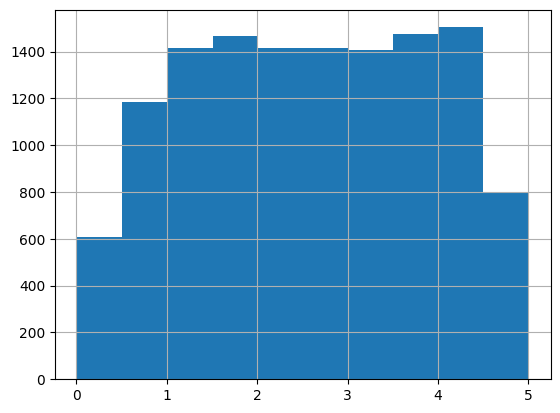

In [41]:
histo=df_customers['RFM_Score']
histo.hist()

In [42]:
df_customers["Customer_segment"] = np.where(df_customers['RFM_Score'] >
                                      4.5, "Top",
                                      (np.where(
                                        df_customers['RFM_Score'] > 4,
                                        "High value",
                                        (np.where(
    df_customers['RFM_Score'] > 3,
                             "Medium Value",
                             np.where(df_customers['RFM_Score'] > 1.6,
                            'Low Value', 'Lost'))))))
df_customers.head()

,min,max,mean,sum,count,mode,customer_ID,Recency,R_rank_norm,F_rank_norm,M_rank_norm,RFM_Score,Customer_segment
0,1.45,1960.00,14.85,37565.53,2529,A_LOCAL_COFFEE_SHOP,1,0,100.00,99.94,99.94,5.00,Top
1,1.45,299.00,14.96,15527.67,1038,PUB,100002,1,42.38,69.09,69.09,3.25,Medium Value
2,1.45,1955.00,33.76,22924.49,679,LOCAL_WATERING_HOLE,100019,0,100.00,14.90,14.90,1.38,Lost
3,1.45,381.25,22.95,15927.38,694,6053,100027,0,100.00,17.34,17.34,1.49,Lost
4,1.45,302.50,10.57,13415.13,1269,COFFEE_SHOP,10004,1,42.38,86.17,86.17,3.98,Medium Value


<AxesSubplot:>

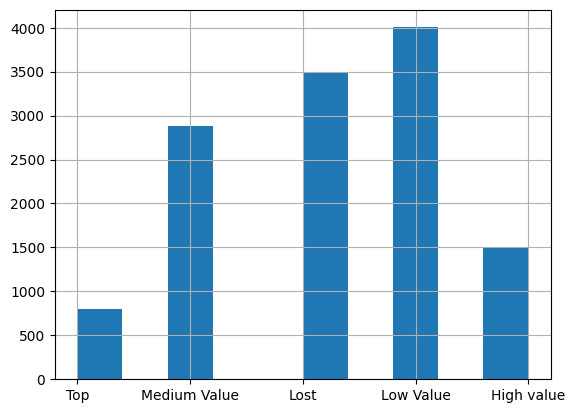

In [43]:
histo=df_customers['Customer_segment']
histo.hist()

# Net amounts

In [44]:
df_between

,from_account,money_amount,to_account,date,transaction_ID,Categorised,type_
2,88339,2.40,40544,2025-01-01,2,betweeen,betweeen
4,18555,2.40,85149,2025-01-01,4,betweeen,betweeen
6,80792,1.95,18555,2025-01-01,6,betweeen,betweeen
19,39262,4.50,30264,2025-01-01,19,betweeen,betweeen
51,53483,5.50,75744,2025-01-01,51,betweeen,betweeen
...,...,...,...,...,...,...,...
12004005,10534,2.40,56045,2025-10-02,12004005,betweeen,betweeen
12004041,62049,2.65,59063,2025-10-02,12004041,betweeen,betweeen
12004073,9671,6.50,44929,2025-10-02,12004073,betweeen,betweeen
12004082,68168,1.45,95491,2025-10-02,12004082,betweeen,betweeen


In [45]:
df_in = df_between.groupby('to_account').agg({'money_amount':pd.Series.sum})


In [46]:
df_in = df_in.reset_index()

In [47]:
df_in.columns = ['customer_ID', 'in']

In [48]:
df_in

,customer_ID,in
0,1,9447.339187
1,100002,671.465385
2,100019,9936.615429
3,100021,280.700000
4,100023,8177.203704
...,...,...
14062,99952,19328.969384
14063,99963,1307.353024
14064,99965,9356.882753
14065,99988,5895.935080


In [49]:
pd.merge(df_customers, df_in)

,min,max,mean,sum,count,mode,customer_ID,Recency,R_rank_norm,F_rank_norm,M_rank_norm,RFM_Score,Customer_segment,in
0,1.45,1960.00,14.85,37565.53,2529,A_LOCAL_COFFEE_SHOP,1,0,100.00,99.94,99.94,5.00,Top,9447.339187
1,1.45,299.00,14.96,15527.67,1038,PUB,100002,1,42.38,69.09,69.09,3.25,Medium Value,671.465385
2,1.45,1955.00,33.76,22924.49,679,LOCAL_WATERING_HOLE,100019,0,100.00,14.90,14.90,1.38,Lost,9936.615429
3,1.45,381.25,22.95,15927.38,694,6053,100027,0,100.00,17.34,17.34,1.49,Lost,1618.741429
4,1.45,302.50,10.57,13415.13,1269,COFFEE_SHOP,10004,1,42.38,86.17,86.17,3.98,Medium Value,1179.087500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12672,1.45,1940.00,26.13,24535.92,939,55586,99952,1,42.38,60.91,60.91,2.91,Low Value,19328.969384
12673,1.45,293.75,19.95,10454.61,524,BAR,99963,1,42.38,1.88,1.88,0.40,Lost,1307.353024
12674,1.45,1835.00,21.32,25518.54,1197,LOCAL_WATERING_HOLE,99965,1,42.38,80.06,80.06,3.72,Medium Value,9356.882753
12675,1.45,1855.00,24.41,22165.08,908,BAR,99988,1,42.38,57.21,57.21,2.75,Low Value,5895.935080


In [50]:
""""df_expenditure.to_csv('/Users/sasha/Desktop/DATASCIENCE/2023/Mini-Project/data.nosync/cleaned_EXPENDITURE_data.csv')
df_customers.to_csv('/Users/sasha/Desktop/DATASCIENCE/2023/Mini-Project/data.nosync/cleaned_CUSTOMERS_data.csv')
df_between.to_csv('/Users/sasha/Desktop/DATASCIENCE/2023/Mini-Project/data.nosync/cleaned_BETWEEN_data.csv')
df.to_csv('/Users/sasha/Desktop/DATASCIENCE/2023/Mini-Project/data.nosync/cleaned_FULL_data.csv')""""

SyntaxError: EOL while scanning string literal (1341848469.py, line 4)